## Cluster latent vectors

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA, SparsePCA
from sklearn.manifold import TSNE

### Load data

In [0]:
# load df with image names
df_image_names = pd.read_csv('/content/drive/My Drive/Image_names_Conv_AE_v4.csv')

# load latent vectors
latent_vectors = np.load('/content/drive/My Drive/Latent_vectors_Conv_AE_v4.npy')

# load real labels
df_true_labels = pd.read_csv('/content/drive/My Drive/Image_labels.csv', sep = ';')

df_true_labels = df_true_labels[['filename','phenotype']]

In [5]:
df_image_names.drop(columns = 'Unnamed: 0', inplace = True)
df_image_names.head()

,image_name
0,CN-CP613_J06_T0001F020L01A01Z01C01_094.png
1,CN-CP613_C10_T0001F022L01A01Z01C01_077.png
2,CN-CP612_I16_T0001F019L01A01Z01C01_042.png
3,CN-CP615_I10_T0001F031L01A01Z01C01_053.png
4,CN-CP613_C07_T0001F006L01A01Z01C01_028.png


In [6]:
df_true_labels.rename(columns = {'filename':'image_name'}, inplace = True)
df_true_labels['phenotype'] = df_true_labels['phenotype'].astype(int)
df_true_labels.head()

,image_name,phenotype
0,CN-CP615_G22_T0001F024L01A01Z01C01_056.png,0
1,CN-CP614_K10_T0001F023L01A01Z01C01_027.png,0
2,CN-CP613_N11_T0001F009L01A01Z01C01_071.png,1
3,CN-CP615_D08_T0001F002L01A01Z01C01_028.png,0
4,CN-CP612_C16_T0001F035L01A01Z01C01_032.png,1


### Merge dataframes (image names and true labels)

In [7]:
print(len(df_image_names), len(df_true_labels))

2568 43666


In [8]:
image_names_labels = pd.merge(df_image_names, df_true_labels, how = 'left', on = 'image_name')
image_names_labels.head()

,image_name,phenotype
0,CN-CP613_J06_T0001F020L01A01Z01C01_094.png,4
1,CN-CP613_C10_T0001F022L01A01Z01C01_077.png,1
2,CN-CP612_I16_T0001F019L01A01Z01C01_042.png,4
3,CN-CP615_I10_T0001F031L01A01Z01C01_053.png,3
4,CN-CP613_C07_T0001F006L01A01Z01C01_028.png,1


In [9]:
print(len(latent_vectors), len(image_names_labels))

2568 2568


### Reduce dimensions of latent vectors

In [0]:
# PCA
pca = PCA(0.8) # generates as many PCs to explain 95% variance
#pca = PCA(n_components = 7) # generates X PCs

pca_values = pca.fit_transform(latent_vectors) 

In [14]:
# 608 dims for 0.95% var
# 163 dims for 0.80%

pca_values.shape

(2568, 163)

### K Means clustering

In [0]:
# loop over diff cluster numbers to find optimal k
min_k = 2
max_k = 40

Sum_of_squared_distances = []

for i in range(min_k,max_k):
  
    result_kmeans = KMeans(n_clusters = i).fit(pca_values)
    
    Sum_of_squared_distances.append(result_kmeans.inertia_)
        

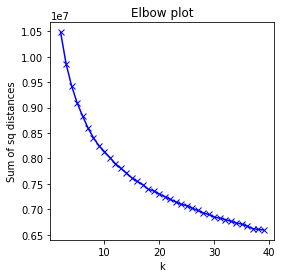

In [0]:
# Plot elbow curve

plt.rcParams['figure.figsize'] = (4, 4)
plt.plot(range(min_k,max_k), Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of sq distances')
plt.title('Elbow plot')
None

In [0]:
n_clusters = 5

result_kmeans = KMeans(n_clusters = n_clusters).fit(pca_values)

cluster_ID = result_kmeans.labels_

image_names_labels['predicted_cluster'] = cluster_ID

### Add predicted cluster to df

In [16]:
image_names_labels.head(5)

,image_name,phenotype,predicted_cluster
0,CN-CP613_J06_T0001F020L01A01Z01C01_094.png,4,2
1,CN-CP613_C10_T0001F022L01A01Z01C01_077.png,1,2
2,CN-CP612_I16_T0001F019L01A01Z01C01_042.png,4,1
3,CN-CP615_I10_T0001F031L01A01Z01C01_053.png,3,0
4,CN-CP613_C07_T0001F006L01A01Z01C01_028.png,1,1


In [17]:
image_names_labels['predicted_cluster'].value_counts()

1    626
0    608
2    526
3    513
4    295
Name: predicted_cluster, dtype: int64

In [18]:
image_names_labels['phenotype'].value_counts()

1    1000
4     992
3     279
2     175
5     122
Name: phenotype, dtype: int64

### Hierarchical clustering

In [0]:
sns.clustermap(pca_values, metric = 'euclidean')
None

### tSNE on reduced dimensions, just to plot in 2D

In [31]:
tsne_data = TSNE(n_components = 2, perplexity = 25, verbose = 1).fit_transform(pca_values)


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 2568 samples in 0.015s...
[t-SNE] Computed neighbors for 2568 samples in 2.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2568
[t-SNE] Computed conditional probabilities for sample 2000 / 2568
[t-SNE] Computed conditional probabilities for sample 2568 / 2568
[t-SNE] Mean sigma: 16.857150
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.390236
[t-SNE] KL divergence after 1000 iterations: 1.723804


### Custom color map

In [0]:
#my_greens = sns.choose_colorbrewer_palette('qualitative', as_cmap = True)
my_cmap_5 = sns.cubehelix_palette(n_colors = 5, rot=-.4, gamma=1.0, hue=0.8, light=0.85, dark=0.15,as_cmap=True)


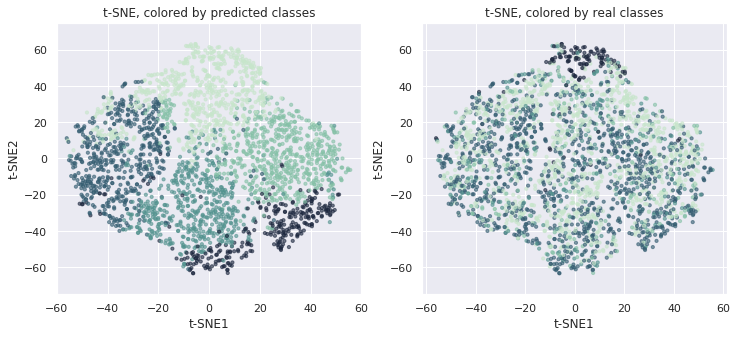

In [38]:
plt.rcParams['figure.figsize'] = (12, 5)

fig, [ax1, ax2] = plt.subplots(1, 2)

scatter = ax1.scatter(x = tsne_data[:,0], y = tsne_data[:,1], c = image_names_labels['predicted_cluster'], cmap = my_cmap_5, alpha = 0.6, s = 10)
ax1.set_xlabel('t-SNE1')
ax1.set_ylabel('t-SNE2')
ax1.set_title('t-SNE, colored by predicted classes')
ax1.set_xlim([-60, 60])
ax1.set_ylim([-75, 75])

ax2.scatter(x = tsne_data[:,0], y = tsne_data[:,1], c = image_names_labels['phenotype'], cmap = my_cmap_5, alpha = 0.6, s = 10)
ax2.set_xlabel('t-SNE1')
ax2.set_ylabel('t-SNE2')
ax2.set_title('t-SNE, colored by real classes')
ax1.set_xlim([-60, 60])
ax2.set_ylim([-75, 75])

plt.savefig('/content/drive/My Drive/Scatter.pdf',orientation='landscape')

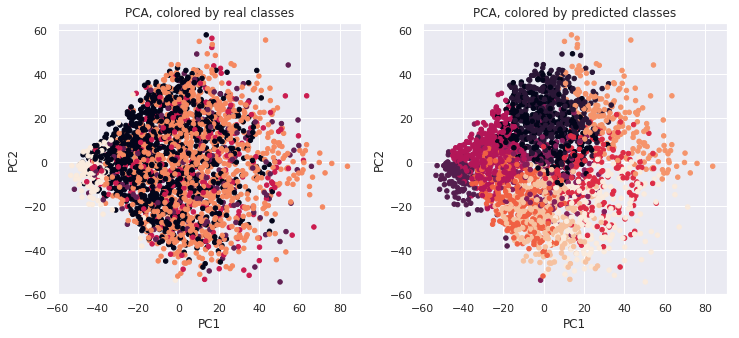

In [0]:
plt.rcParams['figure.figsize'] = (12, 5)

fig, [ax1, ax2] = plt.subplots(1, 2)

ax1.scatter(x = pca_values[:,0], y = pca_values[:,1], c = image_names_labels['phenotype'], s = 20)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PCA, colored by real classes')

ax2.scatter(x = pca_values[:,0], y = pca_values[:,1], c = image_names_labels['predicted_cluster'], s = 20)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('PCA, colored by predicted classes')

None